In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('EURUSD60.csv')

In [3]:
df

,Date,Time,Open,High,Low,Close,Volume
0,2019.12.03,8:00,1.10735,1.10748,1.10711,1.10728,1370
1,2019.12.03,9:00,1.10727,1.10783,1.10716,1.10782,1150
2,2019.12.03,10:00,1.10781,1.10821,1.10743,1.10761,2874
3,2019.12.03,11:00,1.10760,1.10848,1.10754,1.10839,4619
4,2019.12.03,12:00,1.10840,1.10863,1.10760,1.10833,4498
...,...,...,...,...,...,...,...
3532,2020.06.30,8:00,1.12382,1.12397,1.12244,1.12305,3104
3533,2020.06.30,9:00,1.12304,1.12308,1.12037,1.12126,7496
3534,2020.06.30,10:00,1.12125,1.12232,1.12049,1.12227,9462
3535,2020.06.30,11:00,1.12226,1.12273,1.12170,1.12184,9666


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df['Day'] = df['Date'].apply(lambda x: x.day)

In [6]:
df['Hour']=df['Time'].apply(lambda x: x.split(':')[0])

In [7]:
df.drop(['Time', 'Date'], axis=1, inplace=True)

In [8]:
df

,Open,High,Low,Close,Volume,Day,Hour
0,1.10735,1.10748,1.10711,1.10728,1370,3,8
1,1.10727,1.10783,1.10716,1.10782,1150,3,9
2,1.10781,1.10821,1.10743,1.10761,2874,3,10
3,1.10760,1.10848,1.10754,1.10839,4619,3,11
4,1.10840,1.10863,1.10760,1.10833,4498,3,12
...,...,...,...,...,...,...,...
3532,1.12382,1.12397,1.12244,1.12305,3104,30,8
3533,1.12304,1.12308,1.12037,1.12126,7496,30,9
3534,1.12125,1.12232,1.12049,1.12227,9462,30,10
3535,1.12226,1.12273,1.12170,1.12184,9666,30,11


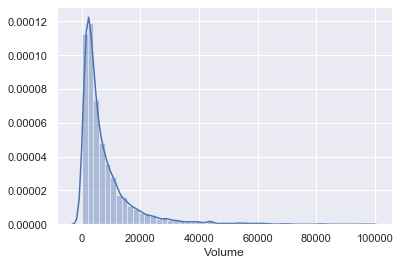

In [9]:
sns.distplot(df['Volume'])

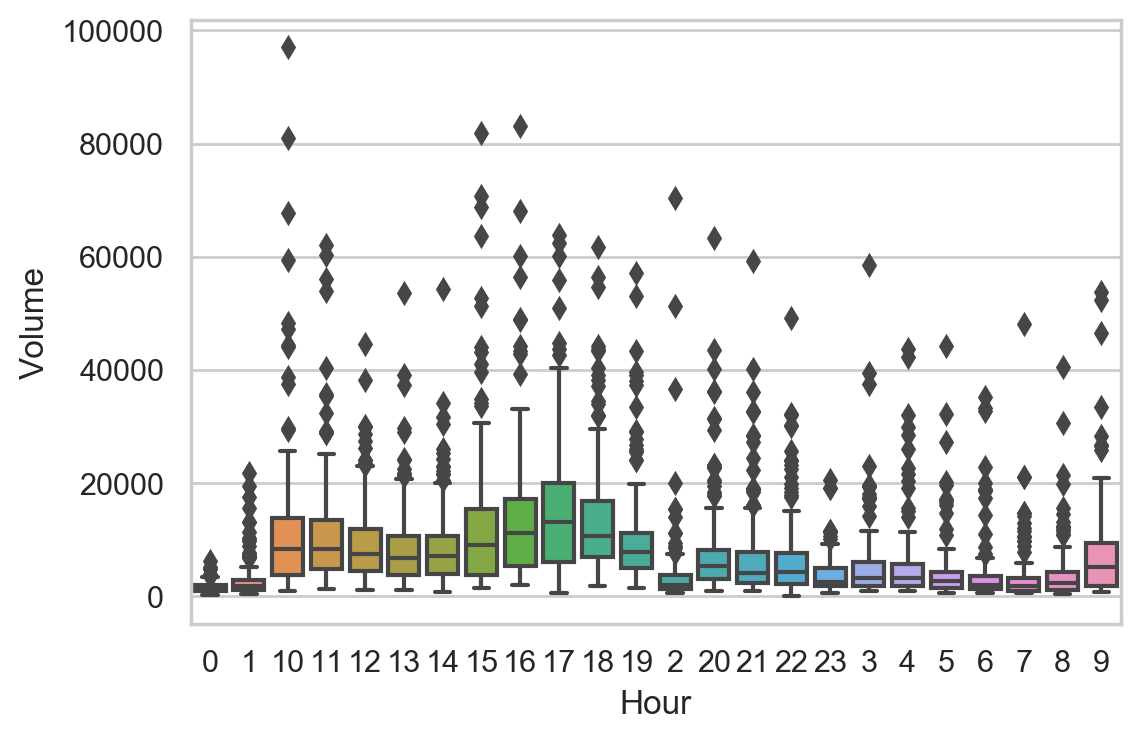

In [10]:
plt.figure(dpi=200)
sns.set_style('whitegrid')
sns.boxplot(df['Hour'], df['Volume'], data=df)

In [11]:
df = df['High']

In [12]:
train_index = round(len(df)*0.05)
train = df[:-train_index].values
test = df[-train_index:].values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train.reshape(-1,1))
test = scaler.transform(test.reshape(-1,1))

In [13]:
batch_len = 5
batch_count = 1 

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
train_generated = TimeseriesGenerator(train, train, length=batch_len, 
                                      batch_size=batch_count)
test_generated = TimeseriesGenerator(test, test, length=batch_len, 
                                     batch_size=batch_count)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [15]:
lstm = Sequential()
lstm.add(LSTM(150, activation='relu', 
              input_shape=((batch_len,train.shape[1]))))
lstm.add(Dense(1))

In [16]:
lstm.compile(optimizer='adam', loss='mse')

In [17]:
lstm.fit(train_generated, validation_data=test_generated, epochs=12)
         #,callbacks=[EarlyStopping(patience=3)])

Epoch 1/12
3355/3355 [==============================] - 17s 5ms/step - loss: 0.0018 - val_loss: 3.0065e-04
Epoch 2/12
3355/3355 [==============================] - 17s 5ms/step - loss: 5.5468e-04 - val_loss: 1.5338e-04
Epoch 3/12
3355/3355 [==============================] - 19s 6ms/step - loss: 3.6856e-04 - val_loss: 3.7728e-04
Epoch 4/12
3355/3355 [==============================] - 18s 5ms/step - loss: 3.2976e-04 - val_loss: 2.6553e-04
Epoch 5/12
3355/3355 [==============================] - 19s 6ms/step - loss: 2.9614e-04 - val_loss: 1.7410e-04
Epoch 6/12
3355/3355 [==============================] - 18s 5ms/step - loss: 2.7506e-04 - val_loss: 4.5594e-04- ETA: 0s - loss: 2
Epoch 7/12
3355/3355 [==============================] - 17s 5ms/step - loss: 2.7962e-04 - val_loss: 1.3586e-04
Epoch 8/12
3355/3355 [==============================] - 18s 5ms/step - loss: 2.6671e-04 - val_loss: 1.3230e-04
Epoch 9/12
3355/3355 [==============================] - 19s 6ms/step - loss: 2.6192e-04 - val_los

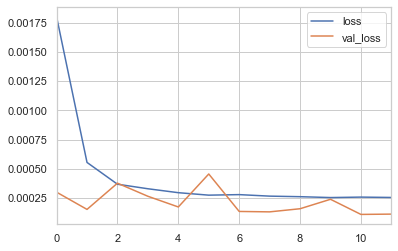

In [18]:
lstm_losses = pd.DataFrame(lstm.history.history)
lstm_losses.plot()

In [19]:
from sklearn.metrics import mean_squared_error

In [20]:
true_predictions=scaler.inverse_transform(lstm.predict(test_generated))

In [21]:
rmse = mean_squared_error(scaler.inverse_transform(test)[batch_len:],
                   true_predictions)**0.5

In [22]:
rmse

0.0008793910647624646

In [23]:
forecast = pd.DataFrame()
forecast['Actual_Price'] = scaler.inverse_transform(test[batch_len:]).reshape(test.shape[0]-batch_len,)
forecast['Prediction'] = scaler.inverse_transform(lstm.predict(test_generated)).reshape(test.shape[0]-batch_len,)
b=forecast['Actual_Price'][:-1]
a=forecast['Prediction'][1:]
mean_squared_error(a,b)**0.5

0.0002827272010084456

In [24]:
forecast[:5]

,Actual_Price,Prediction
0,1.12214,1.121646
1,1.12181,1.122229
2,1.12191,1.121630
3,1.12182,1.121944
4,1.12150,1.121755


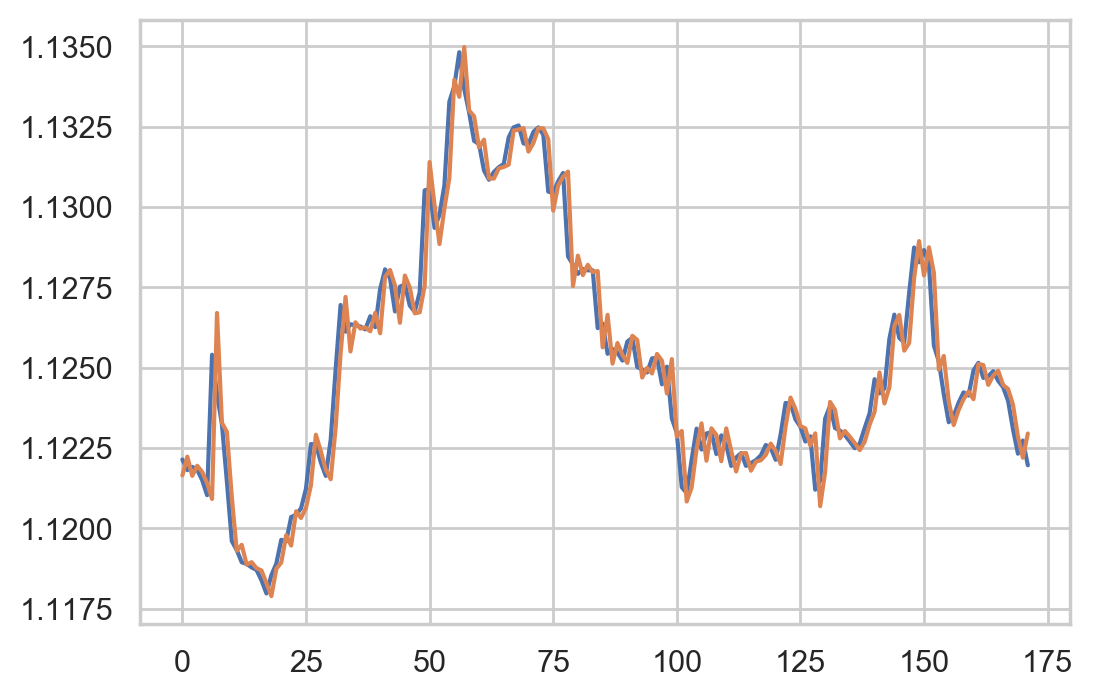

In [25]:
plt.figure(dpi=200)
plt.plot(forecast['Actual_Price'])
plt.plot(forecast['Prediction'])

(75, 100)

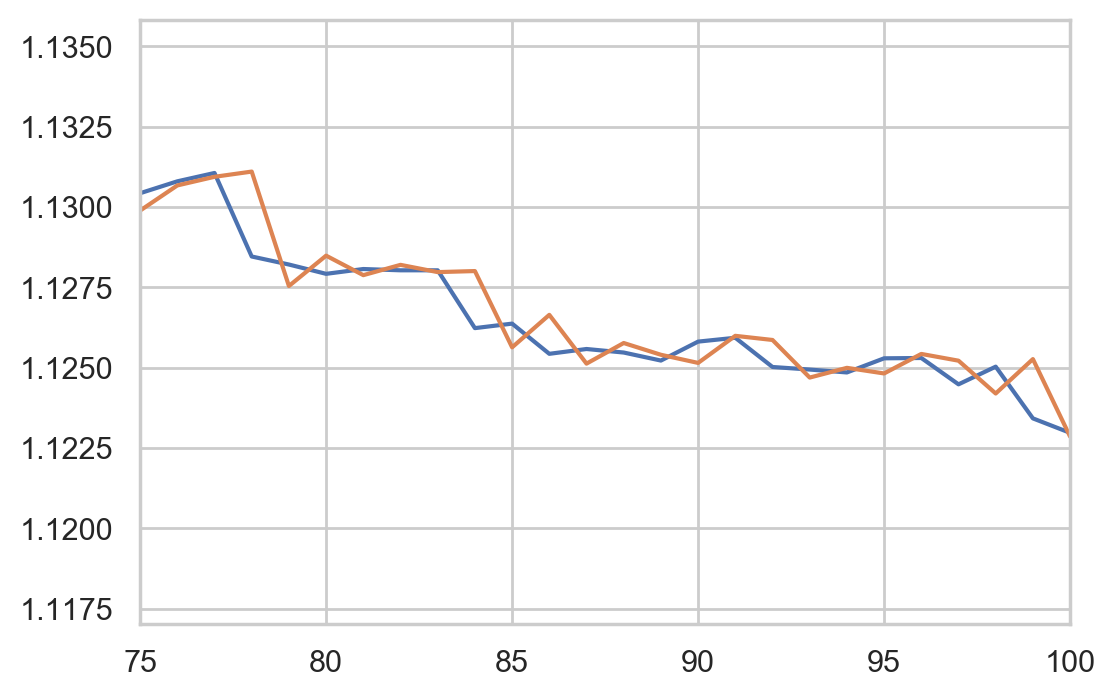

In [26]:
plt.figure(dpi=200)
plt.plot(forecast['Actual_Price'])
plt.plot(forecast['Prediction'])
plt.xlim(75,100)

In [27]:
lst = []

for i in forecast['Prediction']:
    if i<i+1:
        lst.append(i+round(rmse,5)/3)
    else:
        lst.append(i-round(rmse,5)/3)

In [28]:
forecast['Adjusted']= lst

(50, 75)

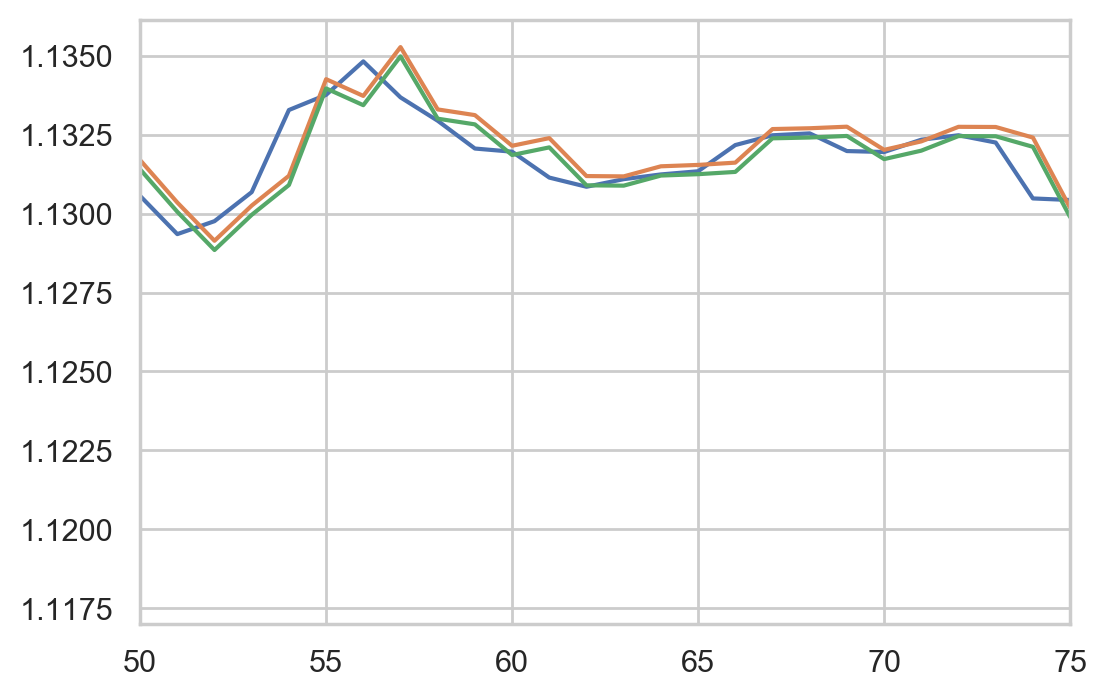

In [29]:
plt.figure(dpi=200)
plt.plot(forecast['Actual_Price'])
plt.plot(forecast['Adjusted'])
plt.plot(forecast['Prediction'])
plt.xlim(50,75)

In [30]:
mean_squared_error(forecast['Actual_Price'],
                  forecast['Adjusted'])**0.5

0.0009172696772108251

In [31]:
mean_squared_error(forecast['Actual_Price'],
                  forecast['Prediction'])**0.5

0.0008793910647624646

In [34]:
test_predictions = []

batch = train[-5:].reshape(1,batch_len,train.shape[1])

for i in range(len(test)):
    
    prediction = lstm.predict(batch)[0]
    
    test_predictions.append(prediction)
    
    batch = np.append(batch[:,1:,:], [[prediction]], axis=1)

In [35]:
true_predictions = scaler.inverse_transform(test_predictions)

In [36]:
my_test_predictions = []
batch = train[-5:].reshape(5,)
for i in range(len(test)):
    prediction = lstm.predict(batch.reshape(1,5,1))[0]
    my_test_predictions.append(prediction)
    batch = np.append(batch[1:], prediction)
true_predictions1 = scaler.inverse_transform(my_test_predictions)

In [38]:
true_test = scaler.inverse_transform(test)

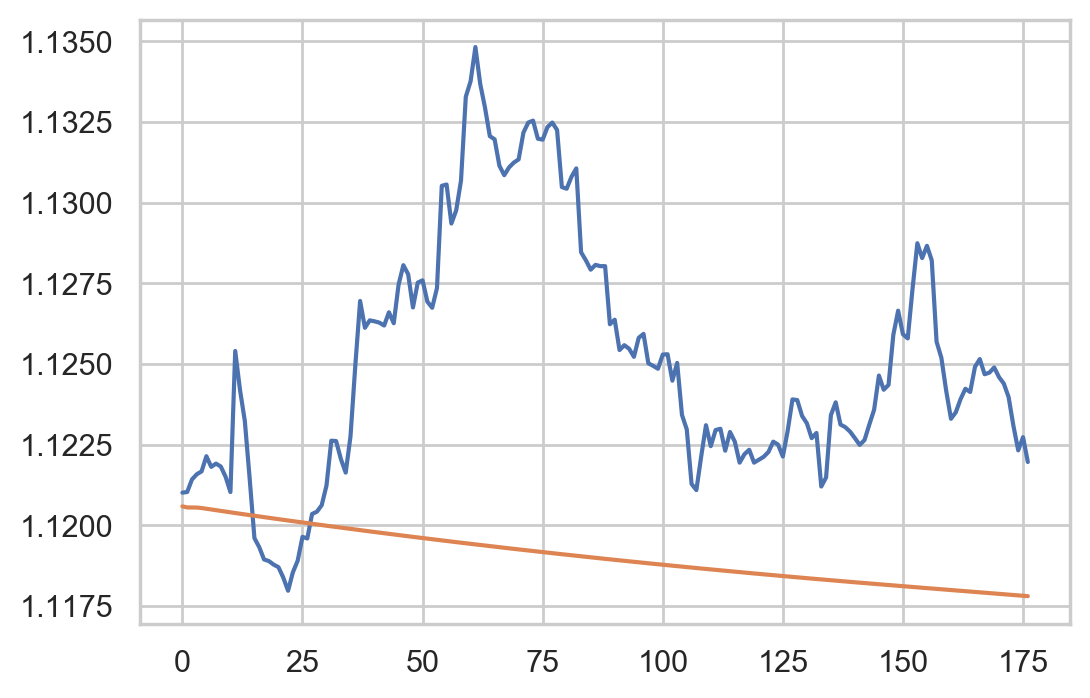

In [41]:
plt.figure(dpi=200)
plt.plot(true_test)
plt.plot(true_predictions)

In [43]:
forecast

,Actual_Price,Prediction,Adjusted
0,1.12214,1.121646,1.121939
1,1.12181,1.122229,1.122522
2,1.12191,1.121630,1.121923
3,1.12182,1.121944,1.122238
4,1.12150,1.121755,1.122049
...,...,...,...
167,1.12397,1.124336,1.124629
168,1.12308,1.123844,1.124137
169,1.12232,1.122852,1.123146
170,1.12273,1.122196,1.122489
